# Analyze Ariane Deduced Tranports

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import xarray as xr

%matplotlib inline

SUBDIR_TMPL = '{:%d%b%y}'
other_nan = ['********************']

/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## Find the daily averaged squared velocity at a key spot

In [2]:
u_vel   = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DuVelocity1hV1')
grid    = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetry2V1')

In [3]:
iY = 341-1; iX = 283-1; iZ = 10 

In [4]:
velocitypt1 = u_vel.uVelocity.sel(time ='2014', depth=iZ, gridX=iX, gridY=iY, method='nearest')
velocitypt2 = u_vel.uVelocity.sel(time ='2015', depth=iZ, gridX=iX, gridY=iY, method='nearest')
velocitypt3 = u_vel.uVelocity.sel(time ='2016', depth=iZ, gridX=iX, gridY=iY, method='nearest')

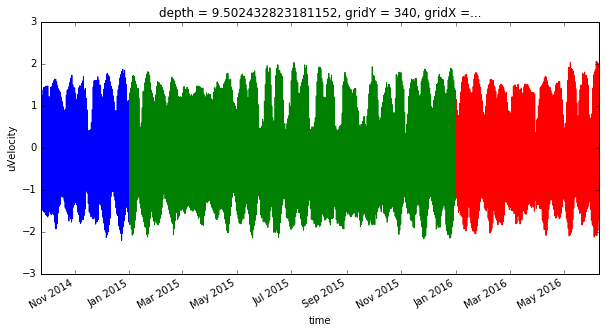

In [5]:
# Yes, do run this.  Its gets the data which makes the next cell happy.
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
velocitypt1.plot()
velocitypt2.plot()
velocitypt3.plot()

In [ ]:
velocity = xr.concat([velocitypt1, velocitypt2, velocitypt3], dim='time')
velsquared = velocity * velocity
day_avg_tide_vel = velsquared.resample('1D', dim='time', how='mean')

In [42]:
#print(day_avg_tide_vel[:])
low_pass_tide = pd.rolling_mean(np.array(day_avg_tide_vel), 10, center=True)
#day_avg_tide_vel.low_pass = low_pass_tide
In [4]: foo = xr.DataArray(data, coords=[times, locs], dims=['time', 'space'])

/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app


AttributeError: cannot set attribute 'low_pass' on a 'DataArray' object. Use __setitem__ style assignment (e.g., `ds['name'] = ...`) instead to assign variables.

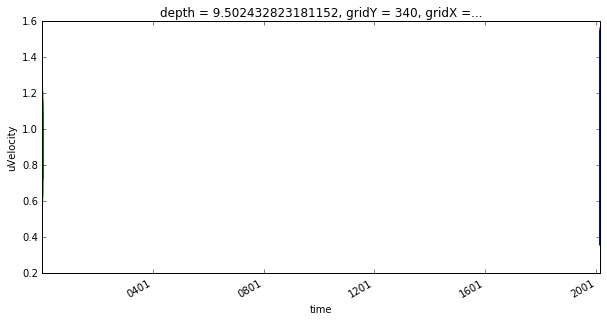

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
day_avg_tide_vel.plot()
ax.plot(low_pass_tide)

## Input Required Ariane Results

In [8]:
rawstats = ['sn', 's1x', 's1x2']
stat = {}
mean = np.zeros((3))
stdev = np.zeros((1))


FRtoBPdir = '/ocean/sallen/allen/research/MEOPAR/Ariane/BackFluxes/StatsFiles/'
FRtoBP = pd.DataFrame(data=None, index=None, 
                           columns=['time', 'depth-mean', 'depth-std',
                                   'salinity-mean', 'flux'],
                           dtype=None, copy=False)    

VStoBPdir = '/ocean/sallen/allen/research/MEOPAR/Ariane/BackFluxesSouth/StatsFiles/'
VStoBP = pd.DataFrame(data=None, index=None, 
                           columns=['time', 'depth-mean', 'depth-std',
                                   'salinity-mean','flux'],
                           dtype=None, copy=False) 

#startdate = datetime.date(2014, 10, 27) + datetime.timedelta(days=15)
startdate = datetime.date(2015, 9, 1)
enddate = datetime.date(2016, 3, 13)
delt = enddate - startdate
for nday in range(delt.days):
    rundate = startdate + datetime.timedelta(days=nday)
    for region, database, dire in zip(['FraserRidge', 'VictoriaSill'], [FRtoBP, VStoBP], [FRtoBPdir, VStoBPdir]): 
        for stattype in rawstats:
            stat[stattype] = pd.read_csv(os.path.join(dire,
                                        stattype+'.'+SUBDIR_TMPL.format(rundate).lower()), 
                                        index_col=0, na_values=other_nan)
            stat[stattype].index = [x.strip() for x in stat[stattype].index]
        for i, parameter in enumerate(['depth', 'sal']):
            themean = stat['s1x'][parameter]/stat['sn']['sn']                
            mean[i] = getattr(themean, region)
        for i, parameter in enumerate(['depth']):
            thestdev = np.sqrt(np.abs((stat['s1x2'][parameter] - 
                                     stat['s1x'][parameter]**2 / stat['sn']['sn'])
                                    / (stat['sn']['sn']-1)))
            stdev[i] = getattr(thestdev, region)
                
        mean[2] = getattr(stat['sn']['flux'], region)
        database.loc[nday] = [rundate, mean[0], stdev[0], mean[1], mean[2]]
FRtoBP =FRtoBP.set_index('time')
VStoBP =VStoBP.set_index('time')



In [9]:
FRtoBP = xr.DataArray(FRtoBP)
VStoBP = xr.DataArray(VStoBP)
tlen = 194
day_u2 = np.array(day_avg_tide_vel.time)
#value_u2 = np.array(day_avg_tide_vel.loc[:])
#print (day_u2[0].type)
#print (startdate.type)
#print (np.where(day_u2 < datetime.datetime(2014, 9, 24)))

#print (day_u2[0])
#print (np.where(day_u2 == 5)[0])

## Look at Raw Transports

NameError: name 'newflux' is not defined

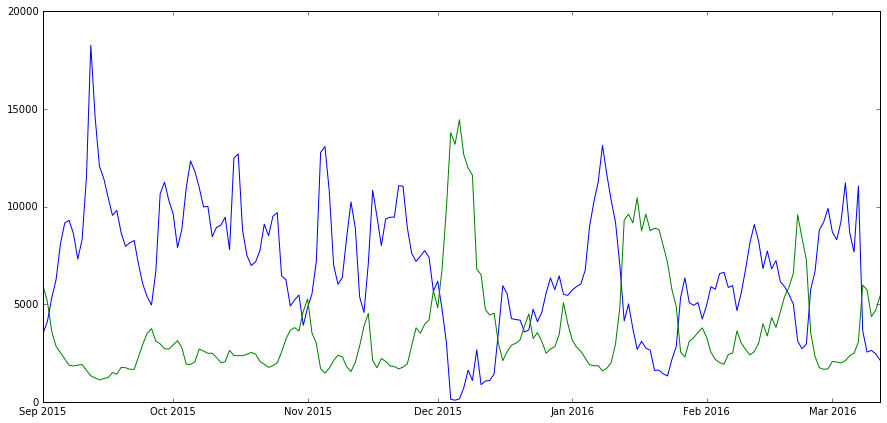

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(FRtoBP.time, (30-FRtoBP.loc[:, 'salinity-mean'])*4000)
ax.plot(FRtoBP.time, (FRtoBP.loc[:, 'depth-mean'])*100)
#ax.plot(FRtoBP.time, (30-FRtoBP.loc[:, 'salinity-mean'])*FRtoBP.loc[:, 'depth-mean']*100)
#ax.plot(VStoBP.time, VStoBP.loc[:, 'flux'])
ax.plot(VStoBP.time[:-3], newflux)
ax.plot(datetime.datetime(2015, 8, 6+15), 0, 'o')
ax.plot(day_avg_tide_vel.time, day_avg_tide_vel.loc[:]*10000.)
ax.set_xlim((datetime.datetime(2015,8, 6+15), datetime.datetime(2016,3, 31)))
#ax.plot(VStoBP.time, (VStoBP.loc[:, 'salinity-mean']-30)*20000)
#ax.plot(FRtoBP.time, FRtoBP.loc[:, 'depth-mean']*2000.)
#ax.plot(FRtoBP.time, (VStoBP.loc[:,'salinity-mean']-FRtoBP.loc[:, 'salinity-mean'])*10000.)

In [ ]:
print ('Fraser River to Boundary Pass')
print (np.mean(FRtoBP.loc[:, 'flux']))
print (np.std(FRtoBP.loc[:, 'flux']))
print ('Normalized Variance = ', np.std(FRtoBP.loc[:, 'flux'])/np.mean(FRtoBP.loc[:, 'flux']))
print ('Victoria to Boundary Pass')
print (np.mean(VStoBP.loc[:, 'flux']))
print (np.std(VStoBP.loc[:, 'flux']))
print ('Normalized Variance = ', np.std(VStoBP.loc[:, 'flux'])/np.mean(VStoBP.loc[:, 'flux']))
print (np.std(newflux))
print ('Normalized Variance = ', np.std(newflux)/np.mean(VStoBP.loc[:, 'flux']))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(VStoBP.loc[:, 'salinity-mean'], VStoBP.loc[:, 'flux'], '*')
#ax.plot(VStoBP.loc[:, 'salinity-mean'], FRtoBP.loc[:, 'flux'], 'o')
x = np.array(VStoBP.loc[:, 'salinity-mean'])
y = np.array(VStoBP.loc[:, 'flux'])
ax.plot(x[3:], y[:-3], 'o')
mb = np.polyfit(x[3:], y[:-3], 1)
xs = np.arange(31.2, 33, 0.1)
ax.plot(xs, mb[0]*xs+mb[1])
newflux = y[:-3] - (mb[0]*x[3:] + mb[1]) 
print (mb[1])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
c1 = np.correlate(FRtoBP.loc[:, 'flux']-np.mean(FRtoBP.loc[:, 'flux']),
                     VStoBP.loc[:, 'flux']-np.mean(VStoBP.loc[:, 'flux']),                                         
                     mode='full')/tlen
scale1 = np.std(FRtoBP.loc[:, 'flux'])-np.mean(FRtoBP.loc[:, 'flux'])
scale2 = np.std(VStoBP.loc[:, 'flux']-np.mean(VStoBP.loc[:, 'flux']))
ax.plot(c1/np.array(scale1*scale2) ,'o-', label='Flux to Flux correlation')
c2 = np.correlate(FRtoBP.loc[:, 'flux']-np.mean(FRtoBP.loc[:, 'flux']),
                     FRtoBP.loc[:, 'flux']-np.mean(FRtoBP.loc[:, 'flux']),                                         
                     mode='full')/tlen
ax.plot(c2/np.array(scale1*scale1),'o-', label='self correlation')
shift = np.argmax(c1) - np.argmax(c2)
print ('Flux to Flux shift =', shift)
c3 = np.correlate(VStoBP.loc[:, 'flux']-np.mean(VStoBP.loc[:, 'flux']),
                     VStoBP.loc[:, 'salinity-mean']-np.mean(VStoBP.loc[:, 'salinity-mean']),                                         
                     mode='full')/tlen
scale3 = np.std(VStoBP.loc[:, 'salinity-mean']-np.mean(VStoBP.loc[:, 'salinity-mean']))
ax.plot(c3/np.array(scale2*scale3),'o-', label = 'VS flux to VS sal')
shift_sal = np.argmax(c3) - np.argmax(c2)
print ('VS flux to VS sal = ', shift_sal)
c4 = np.correlate(VStoBP.loc[:, 'flux']-np.mean(VStoBP.loc[:, 'flux']),
                     -(FRtoBP.loc[:, 'salinity-mean']-np.mean(FRtoBP.loc[:, 'salinity-mean'])),                                         
                     mode='full')/tlen
scale4 = np.std(FRtoBP.loc[:, 'salinity-mean']-np.mean(FRtoBP.loc[:, 'salinity-mean']))
ax.plot(c4/np.array(scale2*scale4),'o-', label = 'VS flux to -FR sal')
shift_salF = np.argmax(c4) - np.argmax(c2)
print (shift_salF)
c5 = np.correlate(VStoBP.loc[:, 'flux']-np.mean(VStoBP.loc[:, 'flux']),
                     VStoBP.loc[:, 'salinity-mean']-np.mean(VStoBP.loc[:, 'salinity-mean']) -
                     (FRtoBP.loc[:, 'salinity-mean']-np.mean(FRtoBP.loc[:, 'salinity-mean'])),                                         
                     mode='full')/tlen
scale5 = np.std(VStoBP.loc[:, 'salinity-mean']-np.mean(VStoBP.loc[:, 'salinity-mean']) -
                     (FRtoBP.loc[:, 'salinity-mean']-np.mean(FRtoBP.loc[:, 'salinity-mean'])))
ax.plot(c5/np.array(scale2*scale5), 'o-', label = 'VS flux to diff sal')
shift_N = np.argmax(c5) - np.argmax(c2)
print (shift_N)
c6 = np.correlate(FRtoBP.loc[:, 'flux']-np.mean(FRtoBP.loc[:, 'flux']),
                     VStoBP.loc[:, 'salinity-mean']-np.mean(VStoBP.loc[:, 'salinity-mean']),                                         
                     mode='full')/tlen
ax.plot(c6/np.array(scale1*scale3),'o-', label = 'FR flux to VS sal')
shift_M = np.argmax(c6) - np.argmax(c2)
print (shift_M)
c7 = np.correlate(FRtoBP.loc[:, 'flux']-np.mean(FRtoBP.loc[:, 'flux']),
                     FRtoBP.loc[:, 'depth-std']-np.mean(FRtoBP.loc[:, 'depth-std']),                                         
                     mode='full')/tlen
scale7 = np.std(FRtoBP.loc[:, 'depth-std']-np.mean(FRtoBP.loc[:, 'depth-std']))
#ax.plot(-c7/np.array(scale1*scale7), 'o-', label = 'FR flux to FR depth')
c8 = np.correlate(FRtoBP.loc[:, 'flux']-np.mean(FRtoBP.loc[:, 'flux']),
                     FRtoBP.loc[:, 'salinity-mean']*FRtoBP.loc[:, 'depth-std'] -
                      np.mean(FRtoBP.loc[:, 'salinity-mean']*FRtoBP.loc[:, 'depth-std']),                                         
                     mode='full')/tlen
scale8 = np.std(FRtoBP.loc[:, 'salinity-mean']*FRtoBP.loc[:, 'depth-std'] -
                      np.mean(FRtoBP.loc[:, 'salinity-mean']*FRtoBP.loc[:, 'depth-std']))
#ax.plot(-c8/np.array(scale1*scale8), 's-', label='FR Flux to Fresh/depth')
c9 = np.correlate(VStoBP.loc[:, 'flux'] - np.mean(VStoBP.loc[:, 'flux']),
                 day_avg_tide_vel.loc[:] - np.mean(day_avg_tide_vel.loc[:]),
                 mode='full')/tlen
scale9 = np.std(day_avg_tide_vel.loc[:] - np.mean(day_avg_tide_vel.loc[:]))
ax.plot(-c9/np.array(scale2*scale9), 's-', label='VS Flux to u2')
print (np.argmin(c9) - np.argmax(c2))
ax.legend()
ax.grid()
ax.set_xlim((0,400))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(FRtoBP.time-datetime.timedelta(days=shift/2), FRtoBP.loc[:, 'flux'])
ax.plot(VStoBP.time+datetime.timedelta(days=shift/2), VStoBP.loc[:, 'flux'])
ax.plot(VStoBP.time+datetime.timedelta(days=shift_sal+shift/2.), (VStoBP.loc[:, 'salinity-mean']-30)*20000.)
ax.plot(FRtoBP.time+datetime.timedelta(days=-shift/2.), (30-FRtoBP.loc[:, 'salinity-mean'])*10000.)

## Normalize the Transport

Idea is to normalize by a velocity = sqrt(g'h) a width and a depth.  For now, we will just use the sqrt(salinity difference) as the only component that actually changes

In [ ]:
difference = VStoBP - FRtoBP
TransportScale = np.sqrt(difference.loc[:, 'salinity-mean'])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(difference.time, TransportScale)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(FRtoBP.time, FRtoBP.loc[:, 'flux']/TransportScale)
ax.plot(VStoBP.time, VStoBP.loc[:, 'flux']/TransportScale)
print ('Fraser Ridge to Boundary Pass')
print (np.mean(FRtoBP.loc[:, 'flux']/TransportScale))
print (np.std(FRtoBP.loc[:, 'flux']/TransportScale))
print ('Normalized Variance = ', np.std(FRtoBP.loc[:, 'flux']/TransportScale) / 
       np.mean(FRtoBP.loc[:, 'flux']/TransportScale))
print ('Victoria Sill to Boundary Pass')
print (np.mean(VStoBP.loc[:, 'flux']/TransportScale))
print (np.std(VStoBP.loc[:, 'flux']/TransportScale))
print ('Normalized Variance = ', np.std(VStoBP.loc[:, 'flux']/TransportScale) / 
       np.mean(VStoBP.loc[:, 'flux']/TransportScale))

## Estimate a Richardson Number

The Richardson number should be Brunt-Vaisala squared divided by the velocity shear squared.  Here we will use g'/h as a measure of the stratification and U/h as the velocity shear to give us a Richardson number of
g'h/U^2.

And until I do everything nice, we will approximate this as the difference in Salinity divided by the velocity squared.

In [ ]:
Ri = (VStoBP-FRtoBP)/day_avg_tide_vel
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(Ri.time, Ri.loc[:, 'salinity-mean'], 'r')
ax.plot(FRtoBP.time, FRtoBP.loc[:, 'flux']/TransportScale/2000.)
ax.plot(VStoBP.time, VStoBP.loc[:, 'flux']/TransportScale/2000.)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(Ri.loc[:, 'salinity-mean'], FRtoBP.loc[:, 'flux']/TransportScale, 'o')
ax.plot(Ri.loc[:, 'salinity-mean'], VStoBP.loc[:, 'flux']/TransportScale, 'o')

### Find the maximum lagged correlation

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
c1 = np.correlate(Ri.loc[:, 'salinity-mean']-np.mean(Ri.loc[:, 'salinity-mean']), 
                     FRtoBP.loc[:, 'flux']/TransportScale-np.mean(FRtoBP.loc[:, 'flux']/TransportScale), 
                     mode='full')
ax.plot(c1,'o-')
c2 = np.correlate(Ri.loc[:, 'salinity-mean']-np.mean(Ri.loc[:, 'salinity-mean']), 
                     VStoBP.loc[:, 'flux']/TransportScale-np.mean(VStoBP.loc[:, 'flux']/TransportScale), 
                     mode='full')
ax.plot(c2,'o-')
c3 = np.correlate(Ri.loc[:, 'salinity-mean']-np.mean(Ri.loc[:, 'salinity-mean']), 
                     Ri.loc[:, 'salinity-mean']-np.mean(Ri.loc[:, 'salinity-mean']), mode='full')
#ax.plot(c3*1000,'o-')

shiftFR = np.argmax(c1) - np.argmax(c3)
shiftVS = np.argmax(c2) - np.argmax(c3)
print (shiftFR, shiftVS)

In [ ]:
Riadv = Ri
Riadv['time'] = Riadv['time'] + datetime.timedelta(days=int(shiftVS))
Riback = Ri
Riback['time'] = Riadv['time'] + datetime.timedelta(days=int(shiftFR))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(Riback.loc[:, 'salinity-mean'], FRtoBP.loc[:, 'flux']/TransportScale, 'o')
ax.plot(Riadv.loc[:, 'salinity-mean'], VStoBP.loc[:, 'flux']/TransportScale, 'o')